# Office football pool - 2015


Because the office is much more fun when there is football.

## The tools used here are free and open-source

- **Python** is a programming language designed to be easy to learn
- **Pandas** is a data manipulation library for Python
- **Scikit-learn** is a data mining / analysis library for Python


#### Meaning you can do this

- at home with your kids
- ...or (*erm*) at your desk right now
- if you don't already have the tools, use [Anaconda][anaconda-download] for a painless bundled installation

And here's the [code for today][repo]
</small>

[anaconda-download]: http://continuum.io/downloads
[repo]: https://github.com/tanyaschlusser/office-nfl-pool#office-nfl-pool

## ...But first we need data

- Lots of sites share or sell data, but disallow further use
- Not to worry, we can still make models and manipulate data from Wikipedia
- → I have pulled (and cleaned) the basic outcomes from 2008-2014 for you
- → and pulled (but not cleaned) the final rosters for teams from 2008-2014

#### Note
To evaluate a cell, type `[control] + [enter]` (at least on OSX). There is also a **Help** menu above for more instructions.

In [1]:
##
# The 'import' statement imports external libraries for use in the interactive session.
# ... and 'import <library> as <nickname>' makes a shorter name for convenience.
#
# The '%matplotlib inline' statement allows inline plots here. (see try.jupyter.org)
#
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Bigger fonts and figures for the demo
matplotlib.rcParams.update({
        'font.size': 14,
        'figure.figsize':(10.0, 8.0),
        'axes.formatter.useoffset':False })

# Better data frame display for the demo
pd.set_option('expand_frame_repr', True)
pd.set_option('max_rows', 18)
pd.set_option('max_colwidth', 14)
pd.set_option('precision',2)

#### OK, Jupyter

If you haven't seen this format before, it is a Jupyter notebook. It runs a web GUI that sends code , grouped in 'cells', to a listening interpreter to execute, then displays the results. Usually you do this on your own computer, but there's [a way to serve notebooks][tryjupyter-github] too. Jupyter notebooks are good for interactive demos like this and for executable reports.

- Start it on the command line by typing `ipython notebook` in a directory above your notebooks, or else from the Anaconda Launcher, click `ipython-notebook`
- The project is written in Python but can execute code for anything that has a "kernel" — a way to receive code and send responses. We are using the IPython kernel, and there's one built for R, Ruby, Haskell, and others ([reference][tryjupyter]).
- The extra `%matplotlib inline` above is a 'magic', a meta-command not part of Python that instructs Jupyter to perform inline plotting.

[tryjupyter]: http://try.jupyter.org
[tryjupyter-github]: https://github.com/jupyter/try.jupyter.org

In [2]:
# Evaluate this cell for documentation on Jupyter magics
%magic

### Pandas I/O

Read a CSV file with the function `pd.read_csv`. The other input options are:

In [3]:
##
# Pro tip:
#    You probably know 'help(object)' will show documentation for the object.
#    'dir(object)' will list all names accessible via the object.
print(' '.join([x for x in dir(pd) if 'read_' in x]))

read_clipboard read_csv read_excel read_fwf read_gbq read_hdf read_html read_json read_msgpack read_pickle read_sql read_sql_query read_sql_table read_stata read_table


In [4]:
## ... and output options:
print(' '.join([x for x in dir(pd.DataFrame) if 'to_' in x]))

_auto_consolidate to_clipboard to_csv to_dense to_dict to_excel to_gbq to_hdf to_html to_json to_latex to_msgpack to_panel to_period to_pickle to_records to_sparse to_sql to_stata to_string to_timestamp to_wide


In [5]:
import os  # in case you're on windows
file_location = os.path.join('data', 'nfl_season2008to2014.csv')
df = pd.read_csv(file_location)

df.head(3)

,Season,Category,Week,Team,Opponent,AtHome,Points,PointsAllowed,Date,Stadium,Overtime,VegasSpread,VegasTotal,VegasWin,Interceptions,Sacks,Fumbles,PenaltyYards
0,2008,regular,1,Arizona Ca...,San Franci...,False,23,13,2008-09-07...,Candlestic...,NaN,1.0,42,True,0,4,0,40
1,2008,regular,2,Arizona Ca...,Miami Dolp...,True,31,10,2008-09-14...,University...,NaN,6.5,40,True,0,2,1,45
2,2008,regular,3,Arizona Ca...,Washington...,False,17,24,2008-09-21...,FedEx Field,NaN,-3.0,43,False,1,2,1,42


### Data description

We have data from the 2008-2014 seasons. I pulled it from Wikipedia because
every other source basically restricts use. The data sets used in this webinare are
also in the repository.

- `Season`, `Week`, and `Date`
- `Team` and `Opponent`
- `Points` and `PointsAllowed`, for the Team and Opponent respectively
- `Stadium` (sometimes)
- `Overtime` (a string with the number of periods of overtime, otherwise Null)
- `AtHome`
    + True if the game is at home (or in London but the team is the 'Home' team)
    + False for the superbowl, for both teams
- `VegasSpread`, `VegasTotal`, `VegasWin`
    + The betting details from before the game. Donated by [TipRanks.com][tipranks]
- `Interceptions`, `Sacks`, `Fumbles`, `PenaltyYards`
    + Also donated by [TipRanks.com][tipranks]
    + `Interceptions`: interceptions thrown
    + `Fumbles`: fumbles made (not fumbles forced)
    + `Sacks`: sacks made by the defense


There are two rows per game, one for the home team and one for the away team, so that we can do aggregations over a team (like a moving average of total points allowed).

[tipranks]: http://tipranks.com/nfl

In [6]:
##
# Transformations using Pandas

# Spread
#    The pandas.DataFrame uses numpy arrays to enable array-wise operations.
df['Spread'] = df.Points - df.PointsAllowed

# PtsPct
df['PointsPercent'] = df.Points / (df.Points + df.PointsAllowed)

# Outcome
#    When assigning to a subset of a column in a DataFrame,
#    use indexing ('ix' or other functions) to identify the subset.
df['Outcome'] = np.nan  # pre-fill the column
df.ix[df.Spread > 0, 'Outcome'] = 'W'
df.ix[df.Spread < 0, 'Outcome'] = 'L'
df.ix[df.Spread == 0, 'Outcome'] = 'T'

# WLT (record)
#    Make sure the data are sorted.
#    Then:
#    Use 'apply' for user-defined functions
#    and 'cumsum' for a running sum; rows with np.nan
#    in the outcome will just add zero
df = df.sort(['Team','Season','Week'])
df['WLT'] = df.groupby(['Team','Season'])['Outcome'].apply(
    lambda o:
        (o == 'W').cumsum().astype(str) + '-' +
        (o == 'L').cumsum().astype(str) + '-'+
        (o == 'T').cumsum().astype(str) )

# WinPct
df['WinPct'] = df.groupby(('Team','Season'))['Spread'].apply(
    lambda s: (0.5 * (s == 0).cumsum() + (s > 0).cumsum()) / s.notnull().cumsum() )

# LastWkBye
#    Make sure the data are sorted.
#    Then flag whether last game was a Bye
df = df.sort(['Team', 'Season','Week'])
df['LastWeekBye'] = df.groupby(['Team','Season'])['Spread'].shift(1).isnull().fillna(False)
df.ix[df.Week == 1, 'LastWeekBye'] = False

# Past5WkAvgPts
#    Make sure the data are sorted.
#    Then use the windowing functions
#    see: http://pandas.pydata.org/pandas-docs/stable/computation.html
#    window size = 5, minimum required observations = 2
df = df.sort(['Team','Season', 'Week'])
df['Past5WkAvgPts'] = df.groupby(['Team']).Points.apply(
    pd.rolling_mean, window=5, min_periods=2).shift(1)

# Past5WkAvgFumbles
#    Some of the sorting seems unnecessary
#    but is good in case you copy and paste a snippet elsewhere...
df = df.sort(['Team','Season','Week'])
df['Past5WkAvgFumbles'] = df.groupby(['Team']).Fumbles.apply(
    pd.rolling_mean, window=5, min_periods=2).shift(1)

# Past5WkInterceptions
df = df.sort(['Team','Season','Week'])
df['Past5WkInterceptions'] = df.groupby('Team').Interceptions.apply(
    pd.rolling_sum, window=5, min_periods=2).shift(1)

# EwmaPenaltyYards, centered at 2 Weeks ago
#  exponentially weighted moving average
df = df.sort(['Team','Season','Week'])
df['EwmaPenaltyYards'] = df.groupby('Team').PenaltyYards.apply(
    pd.ewma, 2).shift(1)


df.head(9)

,Season,Category,Week,Team,Opponent,AtHome,Points,PointsAllowed,Date,Stadium,...,Spread,PointsPercent,Outcome,WLT,WinPct,LastWeekBye,Past5WkAvgPts,Past5WkAvgFumbles,Past5WkInterceptions,EwmaPenaltyYards
0,2008,regular,1,Arizona Ca...,San Franci...,False,23,13,2008-09-07...,Candlestic...,...,10,0.6,W,1-0-0,1.0,False,NaN,NaN,NaN,NaN
1,2008,regular,2,Arizona Ca...,Miami Dolp...,True,31,10,2008-09-14...,University...,...,21,0.8,W,2-0-0,1.0,False,NaN,NaN,NaN,40.0
2,2008,regular,3,Arizona Ca...,Washington...,False,17,24,2008-09-21...,FedEx Field,...,-7,0.4,L,2-1-0,0.7,False,27.0,0.5,0,43.0
3,2008,regular,4,Arizona Ca...,New York Jets,False,35,56,2008-09-28...,Giants Sta...,...,-21,0.4,L,2-2-0,0.5,False,23.7,0.7,1,42.5
4,2008,regular,5,Arizona Ca...,Buffalo Bills,True,41,17,2008-10-05...,University...,...,24,0.7,W,3-2-0,0.6,False,26.5,1.8,4,54.4
5,2008,regular,6,Arizona Ca...,Dallas Cow...,True,30,24,2008-10-12...,University...,...,6,0.6,W,4-2-0,0.7,False,29.4,1.4,4,41.2
6,2008,regular,7,Arizona Ca...,NaN,True,NaN,NaN,Bye,NaN,...,NaN,NaN,NaN,4-2-0,0.7,False,30.8,1.8,5,51.7
7,2008,regular,8,Arizona Ca...,Carolina P...,False,23,27,2008-10-26...,Bank of Am...,...,-4,0.5,L,4-3-0,0.6,True,30.8,2.0,5,51.7
8,2008,regular,9,Arizona Ca...,St. Louis ...,False,34,13,2008-11-02...,Edward Jon...,...,21,0.7,W,5-3-0,0.6,False,32.2,2.2,5,55.4


### Takeaway: Pandas data manipulation

- Arraywise arithmetic (via numpy)
- `apply` functions for custom functions over columns or rows (also see `transform`) 
- [Moving windows][pd_windows], with time shift
- [Groupby][pd_groupby] for operations on grouped subsets
- Subsetting via masks, *e.g.* `df.ix[df.Spread > 0, 'Outcome'] = 'W'`
- Inspection via `df.head()`, `df.tail()`, `df['column'].value_counts`, `df.describe()`

[pd_windows]: http://pandas.pydata.org/pandas-docs/stable/api.html#standard-moving-window-functions
[pd_groupby]: http://pandas.pydata.org/pandas-docs/stable/api.html#function-application-groupby

### Plotting

The Pandas documentation labelled [visualization][viz] is better than the [plotting][pdplot] documentation.
Since it's based on matplotlib they leave details to the
[matplotlib plotting docs][matplotlibdocs].

[viz]: http://pandas.pydata.org/pandas-docs/stable/visualization.html
[pdplot]: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
[matplotlibdocs]: http://matplotlib.org/api/pyplot_summary.html

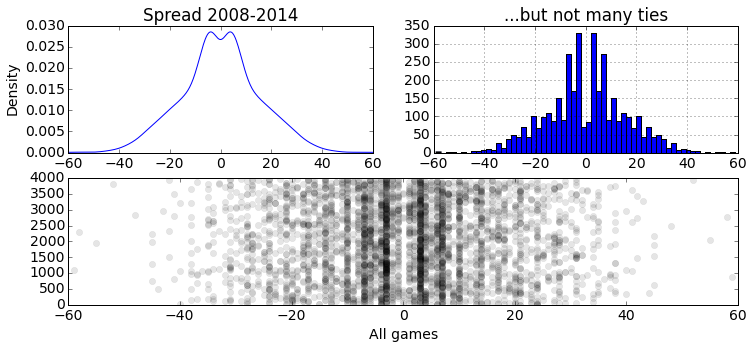

In [7]:
##
# Distribution of the point spread
#
plt.subplot(221)
df.Spread.plot(kind='density')
plt.title('Spread 2008-2014')
plt.xlim((-60,60))
plt.gcf().set_size_inches(12, 5)
    
plt.subplot(222)
df.Spread.hist(bins=60)
plt.title('...but not many ties')

plt.subplot(212)
plt.plot(df.Spread, df.index, 'ko', alpha=0.1)
plt.xlabel('All games')

plt.show()

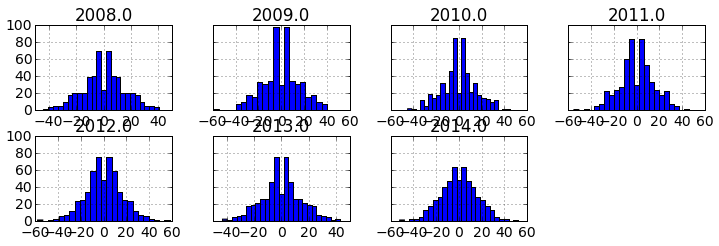

In [8]:
##
# Spread distribution by year
#   -- demonstrates pandas.DataFrame.pivot_table
#
df[['Week', 'Team', 'Season','Spread']].pivot_table(
    index=['Week', 'Team'], columns='Season', values='Spread').hist(
    bins=25, layout=(2,4), figsize=(12,3.5), sharey=True)
plt.show()

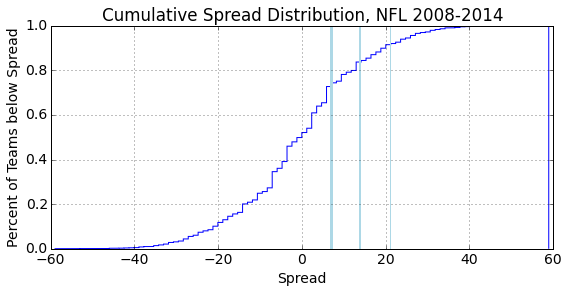

In [9]:
##
# Or cumulative distribution of spread
#    Uses the same 'hist' function as above but with different keyword arguments.
#
df.Spread.hist(cumulative=True, normed=True, histtype='step', bins=100, figsize=(9,4))
#- The shape is consistent season-over-season. If you want to see that uncomment the below....
#df.groupby('Season').Spread.hist(cumulative=True, normed=True, histtype='step', bins=100, figsize=(9,4))

plt.title('Cumulative Spread Distribution, NFL 2008-2014')
plt.ylim(0,1)
plt.xlabel('Spread')
plt.ylabel('Percent of Teams below Spread')
plt.axvline(x=7, hold=None, color='lightblue', linewidth=3)
plt.axvline(x=14, hold=None, color='lightblue', linewidth=2)
plt.axvline(x=21, hold=None, color='lightblue', linewidth=1)
plt.show()

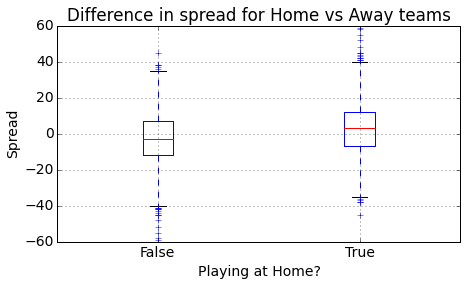

In [10]:
##
# We can do things like explore whether home field advantage exists.
#
df[['AtHome', 'Spread']].boxplot(by='AtHome', figsize=(7,4))
plt.suptitle('')
plt.title('Difference in spread for Home vs Away teams')
plt.ylabel('Spread'); plt.xlabel('Playing at Home?')
plt.show()

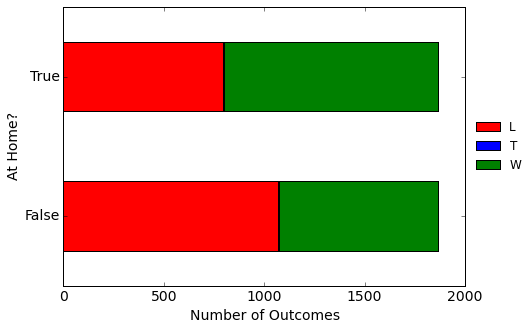

In [11]:
##
# ... by Win counts now
fig = plt.figure()
ax = plt.subplot(111)

pd.crosstab(df.AtHome, df.Outcome).plot(
    ax=ax, kind='barh', stacked=True,
    color=['red','blue', 'green'], figsize=(9,5))

# Mom says label your axes
plt.ylabel('At Home?'); plt.xlabel('Number of Outcomes')

# Shrink current axis by 20% to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
plt.show()

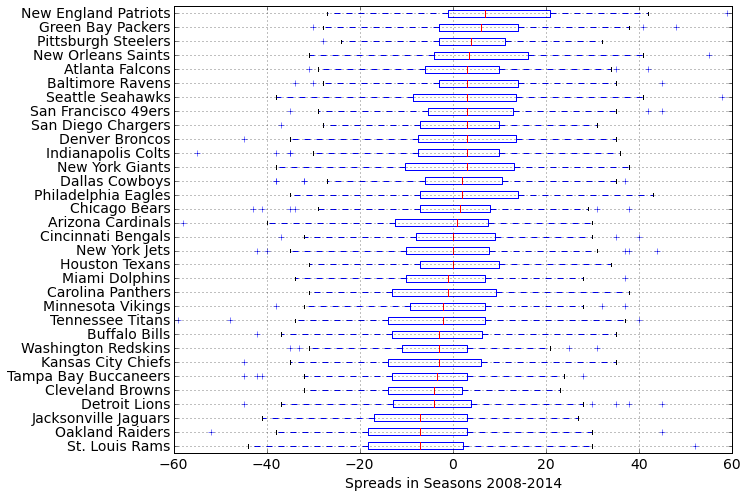

In [12]:
##
# ... or see which teams are consistently great or not
#
df2 = pd.DataFrame({col:vals.Spread for col,vals in df.groupby('Team')})
meds = df2.median().order(ascending=True)
df2[meds.index].boxplot(vert=False, figsize=(5,35), return_type='axes',fontsize=14)
plt.xlabel('Spreads in Seasons 2008-2014')
plt.show()

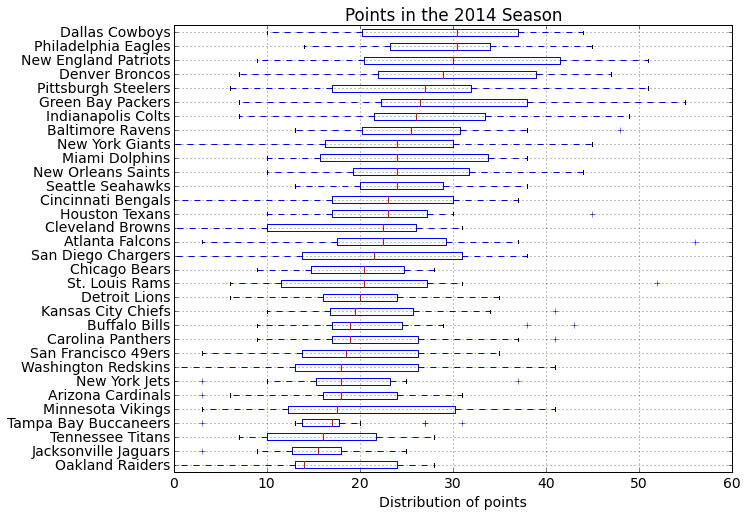

In [13]:
##
# ... Some teams make points but not wins
#
df2 = pd.DataFrame({col:vals.Points for col,vals in df[df.Season==2014].groupby('Team')})
meds = df2.median().order(ascending=True)
df2[meds.index].boxplot(vert=False, figsize=(5,35), return_type='axes',fontsize=14)
plt.xlabel('Distribution of points')
plt.title("Points in the 2014 Season")
plt.show()

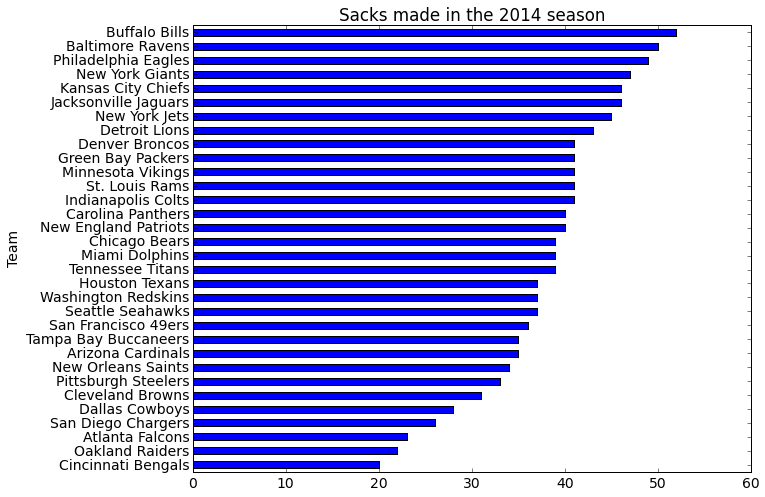

In [14]:
##
# ... How about Sacks?
#
df[(df.Season==2014) & (df.Category == 'regular')
  ].groupby('Team').Sacks.sum().order().plot(kind='barh')
plt.title("Sacks made in the 2014 season")
plt.show()

### Or we can look at a particular team / teams

The year-over-year median scores can be read as "half of the games had at least that spread"...because the median is the value of the middle item if they were sorted.

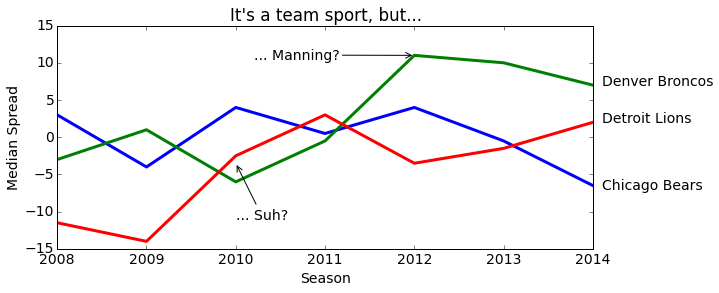

In [15]:
fig = plt.figure()
ax = plt.subplot(111)

tmp = df[df.Team.isin(['Chicago Bears','Detroit Lions','Denver Broncos'])
        ].groupby(['Team', 'Season']
           ).Spread.median().unstack().transpose()
tmp.plot(ax=ax, lw=3, figsize=(12,4), legend=False)

plt.xlabel('Season')
plt.ylabel('Median Spread')

# Shrink current axis by 20% to make room for the annotation
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Legend to the right of the current axis
ax.annotate('... Manning?',(2012, tmp.ix[2012,'Denver Broncos']), xytext=(2010.2, 10.5), 
             arrowprops=dict(arrowstyle='->'))
ax.annotate('... Suh?',(2010, tmp.ix[2012,'Detroit Lions']), xytext=(2010, -11), 
             arrowprops=dict(arrowstyle='->'))

for y, txt in zip([-7,7,2],
                  ['Chicago Bears', 'Denver Broncos', 'Detroit Lions']):
    ax.annotate(txt, (2014, y), xytext=(2014.1, y))

plt.title("It's a team sport, but...")
plt.show()

#### Interpretation: last year,

- Half of the Broncos' games were won by at least a touchdown
- Half of the Lions' games were won by at least a field goal
- Half of the Bears' games were lost by at least a touchdown

## OK that was fun. Let's make a model.

Given details about an upcoming game, predict the point spread. <br/>
[Scikit-learn][scikitlearn] provides machine learning algorithms in Python. Basically:

1. Prepare the data (just spent the last 10 minutes doing this)
2. **Choose a model**  ⇠ (we're here)
3. Use the model to score new data

We will use a Linear Regression because the output we want is numerical (we'd want a Regression of some sort) and it's the model everyone starts with.


[scikitlearn]: http://scikit-learn.org/stable/

### Reminder - available columns

- **Dependent variable**
    + `Spread`
- **Unknown at game start** (can't use)
    + `Outcome`, `Overtime`, `Points`, `PointsAllowed`, `PointsPercent`, `WinPct`, `WLT`,
      `Sacks`, `Fumbles`, `Inteceptions`, `PenaltyYards`
- **Knowns**
    + (useful) `Category`, `AtHome`, `LastWkBye`
    + (cool but if you use them you have to look them up every week)<br>
      `VegasSpread`, 
    + (derived)  `Past5WkAvgFumbles`, `Past5WkInterceptions`, `Past5WkSacks`,
       `EwmaPenaltyYards`, `Past5WkAvgPts`,
    + (too specific? / extraneous) `Season`, `Week`, `Team`, `Opponent`, `Date`, `Stadium`

In [16]:
df.columns

Index([u'Season', u'Category', u'Week', u'Team', u'Opponent', u'AtHome',
       u'Points', u'PointsAllowed', u'Date', u'Stadium', u'Overtime',
       u'VegasSpread', u'VegasTotal', u'VegasWin', u'Interceptions', u'Sacks',
       u'Fumbles', u'PenaltyYards', u'Spread', u'PointsPercent', u'Outcome',
       u'WLT', u'WinPct', u'LastWeekBye', u'Past5WkAvgPts',
       u'Past5WkAvgFumbles', u'Past5WkInterceptions', u'EwmaPenaltyYards'],
      dtype='object')

In [17]:
##
# Combine the data by game, so that the opponent aggregations are available too
tm = df[[
        'Season', 'Category', 'Week', 'Team', 'Opponent', 'Spread', 'AtHome',
        'LastWeekBye',
        'Past5WkAvgPts',
        'Past5WkAvgFumbles', 'Past5WkInterceptions',
        'EwmaPenaltyYards']]
tm.columns = [
        'Season', 'Category', 'Week', 'Team', 'Opponent', 'Spread', 'AtHome',
        'T_LastWkBye',
        'T_5WkAvgPts',
        'T_5WkAvgFumbles', 'T_5WkAvgInterceptions',
        'T_EwmaPenaltyYards']

opp = df[[
        'Season', 'Category', 'Week', 'Team', 'Opponent',
        'LastWeekBye',
        'Past5WkAvgPts',
        'Past5WkAvgFumbles', 'Past5WkInterceptions',
        'EwmaPenaltyYards']]

opp.columns = [
        'Season', 'Category', 'Week', 'Opponent', 'Team',
        'O_LastWkBye',
        'O_5WkAvgPts',
        'O_5WkAvgFumbles', 'O_5WkAvgInterceptions',
        'O_EwmaPenaltyYards']

games = tm.merge(opp, how='inner', on=['Season', 'Category', 'Week', 'Team', 'Opponent'])

games = games[games.Spread.notnull()]
print('games shape:', games.shape)
print('df shape:', df.shape, 'df no bye', df[df.Points.notnull()].shape)

('games shape:', (3732, 17))
('df shape:', (3981, 28), 'df no bye', (3732, 28))


In [18]:
##
# All of the Scikit-learn models are trained with
#   (1) an output column  and
#   (2) an input dataset
#
# Want to predict 'Spread' given known values:
#   ==> Ignore 'Bye' weeks (they have no 'Spread')
#   - Category (regular|postseason)
#   - AtHome (True|False)
#   - LastWeekBye (True|False)
#   - Past5WeekAveragePointsPercent (Numeric)
#   - LastSeasonPlayoffGames (Numeric-count)
#   - LastSeasonPointsPercent (Numeric)
#
no_nulls = games.notnull().all(axis=1)
spread = games[no_nulls].Spread
input_data = games[no_nulls][[
        'Team', # 'Opponent',
        'Category',
        'AtHome',
        'T_LastWkBye',
        'T_5WkAvgPts', 'T_5WkAvgFumbles', 'T_5WkAvgInterceptions', 'T_EwmaPenaltyYards',
        'O_LastWkBye',
        'O_5WkAvgPts', 'O_5WkAvgFumbles', 'O_5WkAvgInterceptions', 'O_EwmaPenaltyYards'
    ]]

# The input column 'Category' contains categories,
# so we have to make dummy variables to use in the regression.
input_data = pd.get_dummies(input_data)

print("Size of the input set:", input_data.shape)
input_data.head(3)

('Size of the input set:', (3696, 45))


,AtHome,T_LastWkBye,T_5WkAvgPts,T_5WkAvgFumbles,T_5WkAvgInterceptions,T_EwmaPenaltyYards,O_LastWkBye,O_5WkAvgPts,O_5WkAvgFumbles,O_5WkAvgInterceptions,...,Team_Pittsburgh Steelers,Team_San Diego Chargers,Team_San Francisco 49ers,Team_Seattle Seahawks,Team_St. Louis Rams,Team_Tampa Bay Buccaneers,Team_Tennessee Titans,Team_Washington Redskins,Category_postseason,Category_regular
2,False,False,27.0,0.5,0,43.0,False,18.0,0.5,0,...,0,0,0,0,0,0,0,0,0,1
3,False,False,23.7,0.7,1,42.5,False,19.7,1.7,4,...,0,0,0,0,0,0,0,0,0,1
4,True,False,26.5,1.8,4,54.4,False,27.2,1.2,2,...,0,0,0,0,0,0,0,0,0,1


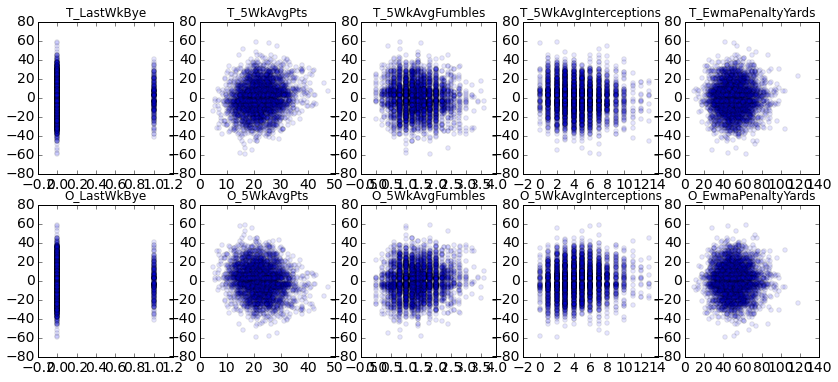

In [19]:
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(14, 6)

cols = ('T_LastWkBye', 'T_5WkAvgPts', 'T_5WkAvgFumbles', 'T_5WkAvgInterceptions', 'T_EwmaPenaltyYards',
        'O_LastWkBye', 'O_5WkAvgPts', 'O_5WkAvgFumbles', 'O_5WkAvgInterceptions', 'O_EwmaPenaltyYards')

for ax, col in zip(axs.flatten(), cols):
    ax.scatter(y=games.Spread, x=games[col], alpha=0.1)
    ax.set_title(col, fontsize=12)

plt.show()

## Set up to do cross-validation

- We are using [sklearn.cross_validation][sklearncv]
- There is also a module for train/test splits (`sklearn.train_test_split`)
- What we're doing is possible thanks to the consistent API

[sklearncv]: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation

In [20]:
# Set up cross-validation
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

def perform_kfold_cross_validation(model, all_X, all_y, k=5):
    """Calculate root mean squared error for each cross-validation fold.
    
    Parameters:
        model - a scikit learn model
        all_X - a pandas DataFrame with the observed input data
        all_y - a pandas Series with the observed outcome
        k - number of cross validation folds (test set will be 1/k of the data)
    
    Return value:
        An array of length 'k' with the root mean squared error
        for each fold.
    """
    # 'folds' is a generator that will yield pairs of arrays (train, test)
    # selecting row numbers for training/testing
    folds = cross_validation.KFold(n=len(all_y), n_folds=k)
    RMSE = []    # root mean squared errors
    # Loop over the cross-validation folds
    for training, testing in folds:
        # Get the training and test splits
        training = all_X.index[training]
        testing = all_X.index[testing]
        X_train, X_test = all_X.ix[training], all_X.ix[testing]
        y_train, y_test = all_y.ix[training], all_y.ix[testing]
    
        # Train the model
        model.fit(X_train, y_train)
        # Use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_fitted)))
    # Leave the model fit to the entire dataset
    model.fit(all_X, all_y)
    # And return the array of root mean squared errors
    return RMSE

### Try out some regression models

As an R user, [scikit-learn's consistent API][sklearn_api] is really a delight.

The lack of diagnostics are bothersome — but in this new 'data science' world it looks like we don't care about scrutinizing the model so long as the cross-validations hold up. Ha. The simple API means switching models is as simple as changing a class name, and the [actual documentation][sklearn_doc] is detailed enough to describe when to use which models.

We won't tune the models here but [sklearn.grid_search][grid_search] provides an api that will exhaustively explore a user-specified grid of (model-specific) tuning parameters.


To show the versatility of the api, we are using
- Linear regression
    + Least squares <span style="color:gray">(minimize distance between actual and prediction)</span>
    + Ridge  <span style="color:gray">(add a penalty to pull coefficients toward zero)</span>
- Regression tree <span style="color:gray">(try to handle the nonlinearity and discrete results)</span>
- Ensemble methods <span style="color:gray">(there are other ones than just trees)</span>
    + Random forest
    + Gradient boosting
- Support vector machine <span style="color:gray">(had no idea this could be for something other than classification)</span>

[wikiL1]: https://en.wikipedia.org/wiki/Regularization_(mathematics)#Regularization_in_statistics_and_machine_learning
[grid_search]: http://scikit-learn.org/stable/modules/grid_search.html
[sklearn_api]: http://scikit-learn.org/stable/modules/classes.html
[sklearn_doc]: http://scikit-learn.org/stable/user_guide.html

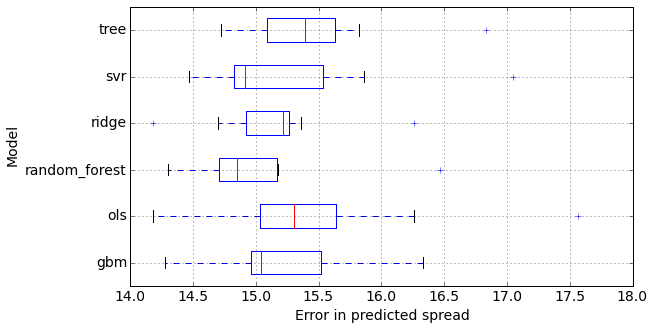

In [21]:
##
# Some popular regression models
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import tree

# To see available tuning settings are for a model,
# call help on its initialization function, e.g. :
#  help(linear_model.Ridge.__init__)
models = dict(
    ols = linear_model.LinearRegression(),
    gbm = ensemble.GradientBoostingRegressor(max_depth=5),
    ridge = linear_model.Ridge(),
    svr = svm.LinearSVR(epsilon=2),
    tree = tree.DecisionTreeRegressor(max_depth=5),
    random_forest = ensemble.RandomForestRegressor(n_estimators=5, max_depth=5)
)

rmses = {}
for name, model in models.items():
    rmses[name] = perform_kfold_cross_validation(model, input_data, spread, k=8)
    
pd.DataFrame(rmses).boxplot(vert=False, return_type='axes')
plt.gcf().set_size_inches(9, 5)
plt.xlabel("Error in predicted spread"); plt.ylabel("Model")
plt.show()

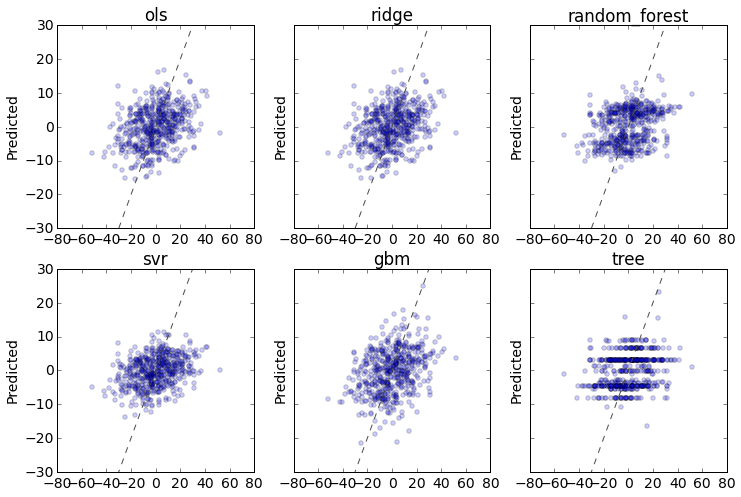

In [22]:
fig, axs = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(12, 8)

# Make the train/test split be pre-2014/2014
train = games[no_nulls].Season < 2014
test = games[no_nulls].Season == 2014

for (ax, (name, model)) in zip(axs.flatten(), models.items()):
    model.fit(input_data.ix[train], spread[train])
    ax.scatter(x=spread[test], y=model.predict(input_data.ix[test]), alpha=0.2)
    ax.plot((-60,60), (-60,60), ls="--", c=".3", color='gray')  # Diagonal line 1=1
    ax.set_title(name)
    ax.set_ylim(-30,30)
    ax.set_ylabel('Predicted')
    
plt.show()

## Well, then. Kind of disappointing.
But if this were easy, everyone would be doing it, right?

Moving on..

- Guess the spread
- **Pick the winners / Confidence pool** ⇠ 
- Survivor pools

#### So, this requires a model with categorical output:
Given details about an upcoming game, predict who will win. (Win = 'yes' or 'no').

('Size of the input set:', (3696, 75))


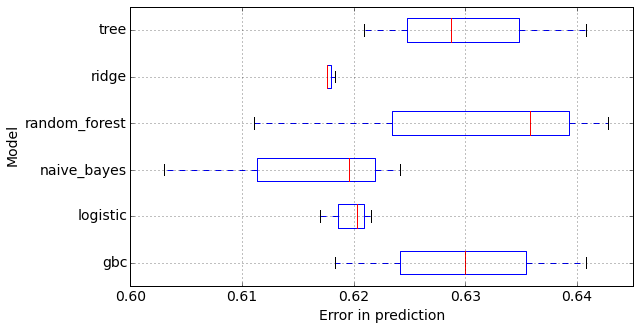

In [23]:
# To see available tuning settings are for a model,
# call help on its initialization function, e.g. :
#  help(linear_model.Ridge.__init__)
from sklearn import naive_bayes

# We can use the Naive Bayes classifier so long as there are no
# columns with negative values
input_data = games[no_nulls][[
        'Team', 'Opponent',
        'AtHome',
        'T_LastWkBye',
        'T_5WkAvgPts', 'T_5WkAvgFumbles', 'T_5WkAvgInterceptions', 'T_EwmaPenaltyYards',
        'O_LastWkBye',
        'O_5WkAvgPts', 'O_5WkAvgFumbles', 'O_5WkAvgInterceptions', 'O_EwmaPenaltyYards'
    ]]

# The input columns 'Team' and 'Opponent', contain categories,
# so we have to make dummy variables to use in the regression.
input_data = pd.get_dummies(input_data)
print("Size of the input set:", input_data.shape)

models = dict(
    logistic = linear_model.LogisticRegression(),
    gbc = ensemble.GradientBoostingClassifier(max_depth=5),
    ridge = linear_model.RidgeClassifier(),
    tree = tree.DecisionTreeClassifier(max_depth=5),
    #svc = svm.LinearSVC(),
    naive_bayes = naive_bayes.MultinomialNB(),  # Can only use if all inputs are positive
    random_forest = ensemble.RandomForestClassifier(n_estimators=10, max_depth=5)
)

win = (spread > 0).astype(int)
rmses = {}
for name, model in models.items():
    rmses[name] = perform_kfold_cross_validation(model, input_data, win, k=3)
    
pd.DataFrame(rmses).boxplot(vert=False, return_type='axes')
plt.gcf().set_size_inches(9, 5)
plt.xlabel("Error in prediction"); plt.ylabel("Model")
plt.show()

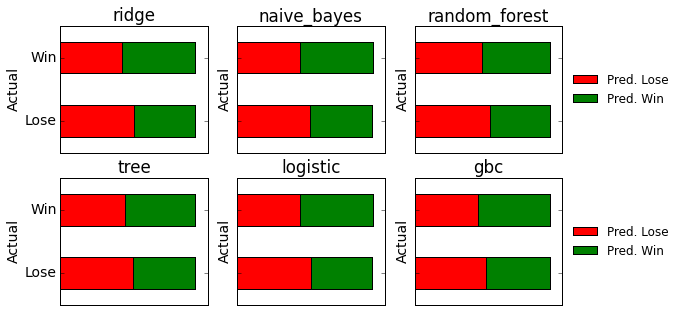

In [24]:
fig, axs = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(12, 8)

# Make the train/test split be pre-2014/2014
train = games[no_nulls].Season < 2014
test = games[no_nulls].Season == 2014

for (ax, (name, model)) in zip(axs.flatten(), models.items()):
    pd.crosstab(win.apply(lambda x: ('Lose', 'Win')[x]),
                pd.Series(('Pred. Lose', 'Pred. Win')[x] for x in model.predict(input_data))).plot(
    ax=ax, kind='barh', stacked=True, legend=None,
    color=['red','green'], figsize=(9,5))
    if ax.is_last_col():
        # Legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
    ax.set_xticks([])
    ax.set_title(name)
    ax.set_ylabel('Actual')

plt.show()

### For the confidence pool

Rank teams by likelihood that they will win. Highest total wins.
- 1 point = lowest confidence
- highest points = highest confidence

For this we don't want a class output, we want a probability:
- `model.decision_function(input_data)` or
- `model._predict_proba(input_data)`

It is this decision function that is used to draw the
Receiver Operating Curve (ROC plot):

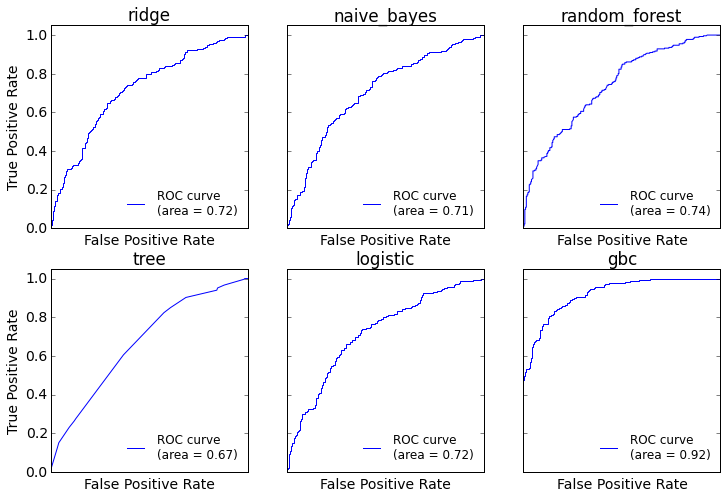

In [25]:
##
# ROC charts
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.metrics import roc_curve, auc

fig, axs = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(12, 8)

for (ax, (name, model)) in zip(axs.flatten(), models.items()):
    try:
        fpr, tpr, _ = roc_curve(win[test], model.predict_proba(input_data[test])[:,1])
    except:
        fpr, tpr, _ = roc_curve(win[test], model.decision_function(input_data[test]))
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve\n(area = {:0.2f})'.format(roc_auc))
    ax.plot((0,0), (1,1), ls="--", c=".3", color='lightgray')  # Diagonal line 1=1
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc='lower right', fontsize=12, frameon=False)
    if ax.is_first_col():
        ax.set_ylabel('True Positive Rate')
    ax.set_xticks([])
    ax.set_xlabel('False Positive Rate')
    ax.set_title(name)

plt.show()

### Code to get  a confidence rating

In [26]:
# Week by week

# Pick the GBC model since that looked best
model = models['gbc']

# Pick columns to show the results
results = games[no_nulls][['Season', 'Week', 'Team', 'Opponent', 'AtHome']]

for wk in range(1, 18):
    # Each week we want only the dates before
    print wk, '...',
    train = (games[no_nulls].Season < 2014) | (games[no_nulls].Week < wk)
    test = (games[no_nulls].Season == 2014) & (games[no_nulls].Week == wk)
    model.fit(input_data[train], win[train])
    probability = model.predict_proba(input_data[test])[:,1]
    results.ix[test, 'Win_Actual'] = win[test]
    results.ix[test, 'Win_Predicted'] = probability

1 ... 2 ... 3 ... 4 ... 5 ... 6 ... 7 ... 8 ... 9 ... 10 ... 11 ... 12 ... 13 ... 14 ... 15 ... 16 ... 17 ...


In [27]:
results.shape

(3696, 7)

In [28]:
results = results[(results.Season==2014) & (results.Week < 18)]

# Merge on the home team
resultsH = results[results.AtHome]
resultsA = results[~results.AtHome]
del resultsH['AtHome']
del resultsA['AtHome']
del resultsA['Win_Actual']

resultsH.columns = ['Season', 'Week', 'Team', 'Opponent', 'Home_Win', 'Home_Pred_W']
resultsA.columns = ['Season', 'Week', 'Opponent', 'Team', 'Away_Pred_W']
resultsH = resultsH.merge(resultsA, on=['Season', 'Week', 'Team', 'Opponent'])

resultsH.columns

Index([u'Season', u'Week', u'Team', u'Opponent', u'Home_Win', u'Home_Pred_W',
       u'Away_Pred_W'],
      dtype='object')

In [29]:
resultsH.sort(['Week', 'Team'])

resultsH['Odds'] = resultsH.Home_Pred_W / resultsH.Away_Pred_W
resultsH['Rank'] = resultsH.groupby('Week').Odds.rank()
resultsH = resultsH.sort(['Week','Rank'], ascending=False)
resultsH[resultsH.Week == 1]

,Season,Week,Team,Opponent,Home_Win,Home_Pred_W,Away_Pred_W,Odds,Rank
184,2014,1,Philadelph...,Jacksonvil...,1,0.8,0.2,4.9,16
120,2014,1,Kansas Cit...,Tennessee ...,0,0.8,0.2,4.6,15
40,2014,1,Chicago Bears,Buffalo Bills,0,0.7,0.3,2.9,14
16,2014,1,Baltimore ...,Cincinnati...,0,0.7,0.3,2.3,13
72,2014,1,Denver Bro...,Indianapol...,1,0.7,0.3,2.2,12
192,2014,1,Pittsburgh...,Cleveland ...,1,0.8,0.4,1.9,11
216,2014,1,Seattle Se...,Green Bay ...,1,0.7,0.4,1.9,10
64,2014,1,Dallas Cow...,San Franci...,0,0.7,0.4,1.8,9
168,2014,1,New York Jets,Oakland Ra...,1,0.6,0.4,1.5,8
224,2014,1,St. Louis ...,Minnesota ...,0,0.5,0.5,1.0,7


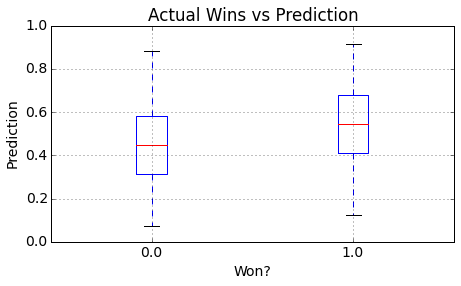

In [30]:
results.ix[results.Season==2014, ['Win_Actual', 'Win_Predicted']].boxplot(
    by='Win_Actual', figsize=(7,4))
plt.suptitle('')
plt.title('Actual Wins vs Prediction')
plt.ylabel('Prediction'); plt.xlabel('Won?')
plt.show()

### Use the model
To make predictions every week there has to be a workflow pipeline

1. Prepare the data
2. Choose a model (just spent the last 20 minutes doing this)
3. **Use the model to score new data** ⇠ (we're here)

Keep tabs on the season in Excel. <br/>
(If you know how to get it from a feed that's fine; you know enough to modify the code.)

#### Overall analysis pipeline

The same as for any model, not just football.

1. Keep a running Excel spreadsheet (or CSV) of the stats you track
2. Run the prediction script from the command line 
    1. Re-run the code to build the dataset with the extra columns running totals/averages
    2. Re-run the code for the model with the new data and use it to predict the new outcomes <br/>
       (or just use the same model, pickled<sup>‡</sup>)
    3. Write the output to an Excel (or CSV) file

<span style="font-size:80%">‡  A [pickle][pypickling] is a seralized Python object </span>

[pypickling]: https://wiki.python.org/moin/UsingPickle

In [31]:
# The script below does just this
%run make_predictions.py

Here we go...
Reading historical data from data/nfl_season2008to2014.csv
Reading this season's data from excel_files/season2015_datasheet.xlsx
Finished.
The prediction is in excel_files/prediction.xlsx on tab prediction on 01 Sep 2015



In [32]:
# And the other code
%run extra_code/make_datasheet.py

Reading the season schedule from data/nfl_season2015.csv
...
Finished.
The blank datasheet is in excel_files/season2015_datasheet.xlsx



In [33]:
# ...Finally
%run extra_code/make_gamesheets.py

Reading schedule from data/nfl_season2015.csv...
Finished.
Output file is at excel_files/sheets2015.xlsx.

